## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df["user_id"].nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.value_counts()

0    259241
1     35237
Name: converted, dtype: int64

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df[((df['group'] == 'treatment') == True) != ((df['landing_page'] == 'new_page') == True)].count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
treatment_oldpage = df.query('group == "treatment" and landing_page != "new_page"')
control_newpage = df.query('group == "control" and landing_page != "old_page"')

df1 = df.drop(treatment_oldpage.index)
df2 = df1.drop(control_newpage.index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2["user_id"].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
sum(df2["user_id"].duplicated())

1

c. What is the row information for the repeat **user_id**? 

In [12]:
duplicate_df2 = df2[df2.duplicated("user_id")]
duplicate_df2

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop(df2.index[2893])

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
converted = df2.query("converted == 1").shape[0]
total = df2["converted"].shape[0]
converted / total

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
converted_control = df2.query("group == 'control' and converted == 1").shape[0]
total_control = df2.query("group == 'control'").shape[0]

converted_control / total_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
converted_treatment = df2.query("group == 'treatment' and converted == 1").shape[0]
total_treatment = df2.query("group == 'treatment'").shape[0]

converted_treatment / total_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
page_new = df2.query("landing_page == 'new_page'").shape[0]
page_total = df2["landing_page"].shape[0]

page_new / page_total

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

There is not sufficient evidence to support that the new treatment page leads to more conversions than the old treatment page. The treatment page has a probability of conversion of .1188, while the control page has a probability of conversion of .1204. The probability of an individual receving the treatment page or the control page is nearly equal at .5001.



<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

null hypothesis: **$p_{old}$** ≥ **$p_{new}$**

alternative hypothesis: **$p_{old}$** < **$p_{new}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [30]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [31]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [32]:
n_new =  sum(df2.landing_page == 'new_page')
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [33]:
n_old = sum(df2.landing_page == 'old_page')
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [34]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[1-p_new, p_new])
new_page_converted.mean()

0.11909022090702635

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [35]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[1-p_old, p_old])
old_page_converted.mean()

0.11937442350317332

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [36]:
(new_page_converted.sum()/len(new_page_converted)) - (old_page_converted.sum()/len(old_page_converted))

-0.00028420259614696242

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [37]:
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

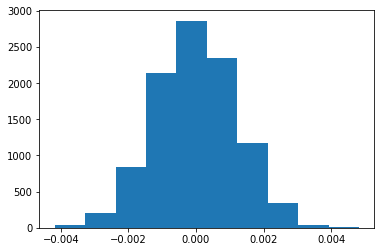

In [38]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [39]:
actual_diff = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
actual_diff

-0.0015782389853555567

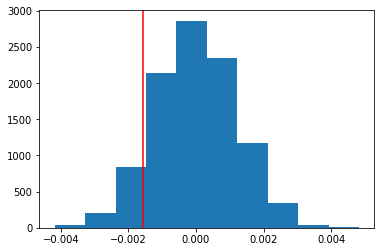

In [42]:
plt.hist(p_diffs)
plt.axvline(actual_diff, color='r');

In [43]:
p_diffs = np.array(p_diffs)
p_val = (p_diffs > actual_diff).mean()
p_val

0.90810000000000002

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

What was calculated is known as a p-value, which given the null hypothesis is true is the probability this statistic will be observed. In order to reject the null hypothesis we would need an alpha of .05 however our p-value is .908 therefore we fail to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [44]:
import statsmodels.api as sm

converted_old = len(df2[df2.landing_page == 'old_page'][df2.converted == 1])
converted_new = len(df2[df2.landing_page == 'new_page'][df2.converted == 1])
n_old = len(df2[df2.landing_page == 'old_page'])
n_new = len(df2[df2.landing_page == 'new_page'])

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [45]:
z_score, p_value = sm.stats.proportions_ztest([converted_new, converted_old], [n_new, n_old], alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


In [46]:
from scipy.stats import norm

print(norm.cdf(z_score)) 
print(norm.ppf(1-(0.05/2))) 

0.094941687241
1.95996398454


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score is -1.31 and therefore does not exceed the 95% confidence of -1.96 - 1.96. The p-value is .91 and still exceeds the alpha of .05. So according to the z-score and p-value we have failed to reject the null hypothesis. This agrees with the findings in parts j and k. We have come to the same conclusion using different means.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [47]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [48]:
df2['intercept'] = 1
df2[['drop', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop('drop', axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [49]:
logit = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [50]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 29 Jul 2019   Pseudo R-squ.:               8.077e-06
Time:                        19:50:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

The p-value associated with the ab_page is .190. It differs because we have different hypothesis.

In part 2 the hypothesis are-

null hypothesis:  𝑝𝑜𝑙𝑑  ≥  𝑝𝑛𝑒𝑤 

alternative hypothesis:  𝑝𝑜𝑙𝑑  <  𝑝𝑛𝑒𝑤

In part 3 the hypothesis are-

null hypothesis:  𝑝𝑜𝑙𝑑 =  𝑝𝑛𝑒𝑤 

alternative hypothesis:  𝑝𝑜𝑙𝑑  !=  𝑝𝑛𝑒𝑤

In Part II the hypothesis only tests in one direction. The null hypothesis states that the old_page ≥ the new_page. We are concerned with which page had a higher conversion rate, this is a one-tailed test. In Part III we are using a regression approach to see if the independant variable had any effect, this is a two-tailed test. This is the reason the value is different.


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Adding more factors into the regression model could be an advantage because it could lower the fitting error and fit the training data with more precision. However if too many factors are added overfitting may arise and in turn will dimish future results. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [51]:
countries = pd.read_csv('countries.csv')
df3 = countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1


In [52]:
country_dummies = pd.get_dummies(df3['country'])
df_country = df3.join(country_dummies)
df_country = df_country.drop(['country', 'CA'], axis=1)
df_country.head()

,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,1
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,1
630002,2017-01-19 19:20:56.438330,control,old_page,0,1,0,0,1
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,1
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,1


In [53]:
logit = sm.Logit(df_country['converted'], df_country[['intercept', 'US', 'UK']])
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366114
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290586
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            2
Date:                Mon, 29 Jul 2019   Pseudo R-squ.:               1.521e-05
Time:                        19:50:07   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1983
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0408      0.027      1.517      0.129      -0.012       0.093
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

All p-values for the countries are greater than .05 therefore we can conclude there is no statistical significance in predicting the conversion of users.

## Conclusion

This project was used to decide whether the e-commerce website should keep their old page, implement their new page, or run a longer experiment to decide the results.

In Part II, our null hypothesis was that the old page was equally or more effective at converting users than the old page. The results concluded that we had a p-value of .908 which is well above the threshold of .05 so therefore we failed to reject the null hypothesis. The z-score was also calculated at -1.31 and did not exceed the 95% confidence of -1.96 - 1.96 and therefore also failed to reject the null hypothesis. 

In Part III, our null hypothesis was that the old page was equal to the new page. We used a logistic regression model to calculate the p-value. The p-value was .190 and therefore failed to reject the null hypothesis.

In Part III, another factor was introduced to the model to avoid Simpson's paradox and to maintain consistency. This factor was the country of the user. There was no indication that the user's country had any significance in their conversion rate. 

In conclusion there is no reason to adopt the new page. There isn't evidence to support that the new page raises the conversion rate for users. It would be in the best interest of the company to keep their old page because it would save time and money while also supporting their users just as well.




<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [57]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0